In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors

In [60]:
cat = Table.read('measurement_single_exposure_superbit_v3.fits')

In [61]:
filtered_cat = cat[(cat['flag'] == 1) & (cat['admom_sigma'] > 0.25)]

In [62]:
true_sigma = np.sqrt(filtered_cat[filtered_cat["T_noshear"]>0]['true_T']/2)
sigma_admom = filtered_cat[filtered_cat["T_noshear"]>0]['admom_sigma']
measured_sigma = np.sqrt(filtered_cat[filtered_cat["T_noshear"]>0]['T_noshear']/2)

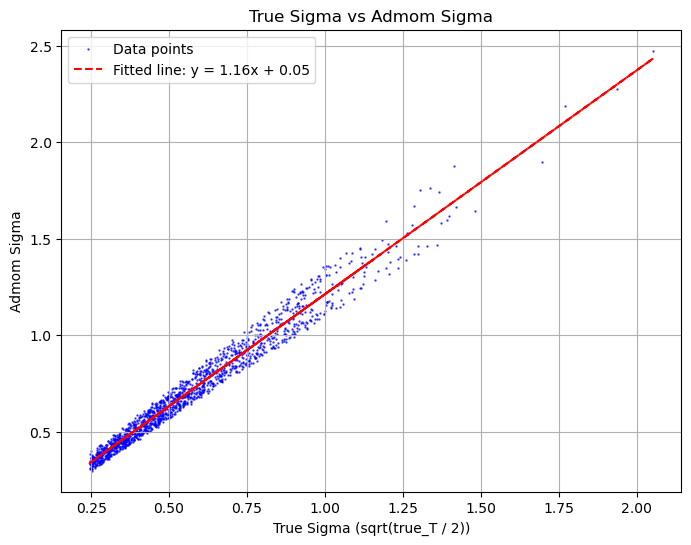

In [64]:
# Calculate the minimum values
min_true_sigma = np.min(true_sigma)
min_sigma_admom = np.min(sigma_admom)

# Fit a line to the data (1st degree polynomial)
coefficients = np.polyfit(true_sigma1, measured_sigma1, 1)
slope, intercept = coefficients
#slope, intercept = 1, 0
fit_line = slope * true_sigma1 + intercept


# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(true_sigma1, measured_sigma1, label='Data points', color='blue', alpha=0.7, s=0.5)

# Add y = x line
plt.plot(true_sigma1, fit_line, label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}', color='red', linestyle='--')

# Add vertical and horizontal lines at the minimum values
#plt.axvline(min_true_sigma, color='green', linestyle='--', label=f'Min True Sigma: {min_true_sigma:.2f}')
#plt.axhline(min_sigma_admom, color='orange', linestyle='--', label=f'Min Admom Sigma: {min_sigma_admom:.2f}')

# Labels and title
plt.title('True Sigma vs Admom Sigma')
plt.xlabel('True Sigma (sqrt(true_T / 2))')
plt.ylabel('Admom Sigma')

# Grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [65]:
# Clean all required lists
r11_clean = filtered_cat['r11']
r12_clean = filtered_cat['r12']
r21_clean = filtered_cat['r21']
r22_clean = filtered_cat['r22']

c1_psf_clean = filtered_cat['c1_psf']
c2_psf_clean = filtered_cat['c2_psf']

c1_clean = filtered_cat['c1']
c2_clean = filtered_cat['c2']

# Compute Gamma Response Matrix
R_gamma = np.array([
    [np.mean(r11_clean), np.mean(r12_clean)],
    [np.mean(r21_clean), np.mean(r22_clean)]
])

# Compute PSF additive bias and Gamma correction vector
c_psf = np.array([np.mean(c1_psf_clean), np.mean(c2_psf_clean)])
c_gamma = np.array([np.mean(c1_clean), np.mean(c2_clean)])

# Check if R_gamma is invertible
if np.linalg.det(R_gamma) == 0:
    print("\nWarning: R_gamma is singular (non-invertible). Using pseudo-inverse instead.")
    R_inv = np.linalg.pinv(R_gamma)  # Use pseudo-inverse to avoid errors
else:
    R_inv = np.linalg.inv(R_gamma)

c_total = c_psf + c_gamma

# Print results
print("\nGamma Response Matrix (R_gamma):")
print(R_gamma)

print("\nPSF Correction Vector (c_psf):")
print(c_psf)

print("\nGamma Correction Vector (c_gamma):")
print(c_gamma)

print("\nInverse of Gamma Response Matrix (R_inv):")
print(R_inv)



Gamma Response Matrix (R_gamma):
[[ 0.86069417  0.00496313]
 [-0.00369091  0.8307396 ]]

PSF Correction Vector (c_psf):
[-1.5732307e-07 -1.0088989e-06]

Gamma Correction Vector (c_gamma):
[-2.7035567e-06 -2.1257154e-04]

Inverse of Gamma Response Matrix (R_inv):
[[ 1.1618232  -0.00694114]
 [ 0.00516188  1.2037158 ]]


In [66]:
g1_Rinv, g2_Rinv = [], []
g_noshear_list = filtered_cat["g_noshear"]
for i in tqdm(range(len(g_noshear_list))):
    g_noshear = g_noshear_list[i]
    g_biased = g_noshear - c_total
    g_corrected = np.einsum('ij,nj->ni', R_inv, g_biased[np.newaxis, :]).squeeze()
    #g_corrected[0] = g_biased[0]/np.mean(r11_clean)
    #g_corrected[1] = g_biased[1]/np.mean(r22_clean)
    g1_Rinv.append(g_corrected[0])
    g2_Rinv.append(g_corrected[1])

100%|██████████| 1587/1587 [00:00<00:00, 44438.84it/s]


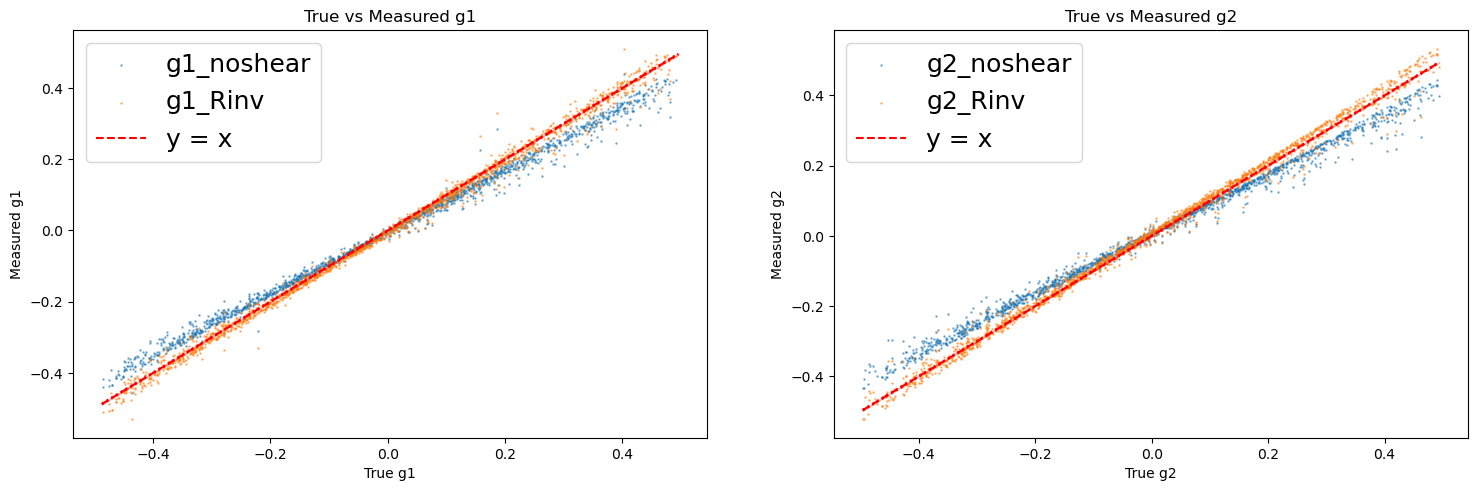

In [67]:
# Compute the min and max values for the line limits
cat = filtered_cat
g1_min = np.min(cat["true_g1"])
g1_max = np.max(cat["true_g1"])
g2_min = np.min(cat["true_g2"])
g2_max = np.max(cat["true_g2"])

g1_error_allowed = np.sqrt(np.median(cat["g_cov_noshear"][:,0]))
g2_error_allowed = np.sqrt(np.median(cat["g_cov_noshear"][:,3]))

# Scatter plot: True vs Measured g1
plt.figure(figsize=(18, 18))

true_sigma = np.sqrt(cat['true_T']/2)
# Plot for g1
plt.subplot(3, 2, 1)
plt.scatter(cat["admom_g1"], cat["g_noshear"][:,0], alpha=0.5, s=0.7, label="g1_noshear")
plt.scatter(cat["admom_g1"], g1_Rinv, alpha=0.5, s=0.7, label="g1_Rinv")
#sc = plt.scatter(cat["true_g1"], g1_Rinv, alpha=0.5, s=10, c=true_sigma, cmap='viridis',  label="g1_Rinv")  # Use c=true_sigma for color

# Add colorbar
#cbar = plt.colorbar(sc)
#cbar.set_label("True Sigma (Size Indicator)")

# y=x line
plt.plot([g1_min, g1_max], [g1_min, g1_max], 'r--', label="y = x")  

# Upper and lower bounds
plt.plot([g1_min, g1_max], [g1_min + g1_error_allowed, g1_max + g1_error_allowed], 'r:')
plt.plot([g1_min, g1_max], [g1_min - g1_error_allowed, g1_max - g1_error_allowed], 'r:')

# Optional: Shaded region for error range
plt.fill_between([g1_min, g1_max], [g1_min - g1_error_allowed, g1_max - g1_error_allowed], 
                 [g1_min + g1_error_allowed, g1_max + g1_error_allowed], color='red', alpha=0.2)

plt.xlabel("True g1")
plt.ylabel("Measured g1")
plt.title("True vs Measured g1")
plt.legend(fontsize=18)

# Scatter plot: True vs Measured g2
plt.subplot(3, 2, 2)
plt.scatter(cat["true_g2"], cat["g_noshear"][:,1], alpha=0.5, s=0.7, label="g2_noshear")
plt.scatter(cat["true_g2"], g2_Rinv, alpha=0.5, s=0.7, label="g2_Rinv")
#sc = plt.scatter(cat["true_g2"], g2_Rinv, alpha=0.5, s=10, c=true_sigma, cmap='viridis',  label="g2_Rinv")  # Use c=true_sigma for color

# Add colorbar
#cbar = plt.colorbar(sc)
#cbar.set_label("True Sigma (Size Indicator)")

# y=x line
plt.plot([g2_min, g2_max], [g2_min, g2_max], 'r--', label="y = x")  

# Upper and lower bounds
plt.plot([g2_min, g2_max], [g2_min + g2_error_allowed, g2_max + g2_error_allowed], 'r:')
plt.plot([g2_min, g2_max], [g2_min - g2_error_allowed, g2_max - g2_error_allowed], 'r:')

# Optional: Shaded region for error range
plt.fill_between([g2_min, g2_max], [g2_min - g2_error_allowed, g2_max - g2_error_allowed], 
                 [g2_min + g2_error_allowed, g2_max + g2_error_allowed], color='red', alpha=0.2)

plt.xlabel("True g2")
plt.ylabel("Measured g2")
#plt.ylim(-0.05, 0.06)
plt.title("True vs Measured g2")
plt.legend(fontsize=18)